In [1]:
import os
from os.path import join, exists
import time
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm
import json

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader as TorchDataLoader

import albumentations as A
from multicamera_keypoints.v0.hrnet import HRNet

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr

def get_grid(W, H, num_keypoints, downsample=4):
    grid = cartesian_product(np.arange(0, W, downsample, dtype=np.float32),
                             np.arange(0, H, downsample, dtype=np.float32))
    grid = np.repeat(grid[None], num_keypoints, axis=0)
    return grid

def uv_to_heatmap(uv, grid, sigma):
    vu = np.copy(np.flip(uv, axis=-1))
    isnan = np.isnan(vu[:, 0])
    vu[isnan] = 0
    y = np.exp(-np.sum((grid - vu[:,None,None,:]) ** 2, axis=-1) / sigma)
    y[isnan] = 0
    return y


class DataLoader(Dataset):
    def __init__(self, annotations, augment=True, crop_size=512,
                 sigma=5, stride=2):
        self.annotations = annotations
        self.image_paths = sorted(self.annotations.keys())
        self.num_keypoints = annotations[self.image_paths[0]].shape[0]
        self.crop_size = crop_size
        self.sigma = sigma

        self.grid = get_grid(
            crop_size, crop_size, 
            self.num_keypoints, 
            downsample=stride)
        
        if augment:
            self.transform = A.Compose(
                [
                    A.ShiftScaleRotate(p=0.8, scale_limit=0.2, rotate_limit=25, border_mode=1),
                    A.GaussNoise(p=0.25),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                ], 
                keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        else:
            self.transform = None

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        keypoints = self.annotations[img_path]
        keypoints_mask = np.isnan(keypoints).any(1)
        keypoints = np.nan_to_num(keypoints)
        image = cv2.imread(img_path)
        
        s = int(np.min(image.shape[:2]))-2
        crop_center = keypoints.sum(0)/(1-keypoints_mask).sum(0)
        crop_center = (crop_center + np.random.normal(0,1,(2,))).astype(int)
        image = crop_image(image, crop_center, s)
        keypoints = keypoints - crop_center + s//2        
        
        if not self.transform is None:
            transformed = self.transform(image=image, keypoints=keypoints)
            image = transformed['image']
            keypoints = np.array(transformed['keypoints'])
            
        margin = (s - self.crop_size)//2
        image = image[margin:-margin,margin:-margin]
        keypoints = keypoints-margin

        heatmap = uv_to_heatmap(keypoints, self.grid, sigma=self.sigma) #* keypoints_mask[:,None,None]
        image = torch.tensor(image[None,:,:,0].astype(np.float32))/255
        heatmap = torch.tensor(heatmap.astype(np.float32))
        return image, heatmap
        
def rgb_to_gray(rgb_kernel):
    gray_kernel = torch.sum(rgb_kernel, dim=1, keepdim=True)
    return gray_kernel

def load_pretrained(hrnet, pretrain_dataset='imagenet'):
    pretrained_path = f'/n/groups/datta/6cam_keypoint_networks/pretrained_weights/{pretrain_dataset}.pth'
    pretrained_weights = torch.load(pretrained_path)
    hrnet_weights = hrnet.state_dict()
    
    hrnet_weights['conv1.weight'] = rgb_to_gray(pretrained_weights['conv1.weight'])
    for key in hrnet_weights.keys():
        if key.startswith('conv1') or key.startswith('final'):
            continue
            
        pretrained_shape = pretrained_weights[key].shape
        hrnet_shape = hrnet_weights[key].shape
        if any([x1 != x2 for x1, x2 in zip(pretrained_shape, hrnet_shape)]):
            print('Warning', key, 'shapes do not match! Skipping.')
            continue
        
        hrnet_weights[key] = pretrained_weights[key]
        
    hrnet.load_state_dict(hrnet_weights)
    return hrnet


def crop_image(image, centroid, crop_size):
    """Crop an image around a centroid.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to crop.

    centroid: tuple of int
        (x,y) coordinates of the centroid.

    crop_size: int or tuple(int,int)
        Size of the crop around the centroid. Either a single int for a square
        crop, or a tuple of ints (w,h) for a rectangular crop.


    Returns
    -------
    image: ndarray of shape (crop_size, crop_size, 3)
        Cropped image.
    """
    if isinstance(crop_size, tuple):
        w, h = crop_size
    else:
        w, h = crop_size, crop_size
    x, y = int(centroid[0]), int(centroid[1])

    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)
    x_max = min(image.shape[1], x + w // 2)
    y_max = min(image.shape[0], y + h // 2)

    cropped = image[y_min:y_max, x_min:x_max]
    padded = np.zeros((h, w, *image.shape[2:]), dtype=image.dtype)
    pad_x = max(w // 2 - x, 0)
    pad_y = max(h // 2 - y, 0)
    padded[
        pad_y : pad_y + cropped.shape[0], pad_x : pad_x + cropped.shape[1]
    ] = cropped
    return padded


# Load data

In [3]:
annotations = {}

## Load new JP 219 rig annotations

In [4]:
annos_dir = './scale_annotation/JP_219_rig_v2_May2024/'
img_dir = join(annos_dir, "images")
camera = "side"
anno_filenames = [
    "tasks_20240516_J04301.json",
    "tasks_20240517_J04502.json",
    "tasks_20240517_J04503.json",
    "tasks_20240518_J04301.json",
    "tasks_20240518_J04303.json",
    "tasks_20240528_J04302.json",
    "tasks_20240528_J04303.json",
    "tasks_20240530_J04304.json",
    
]
anno_paths = [join(annos_dir, "results", anno_file) for anno_file in anno_filenames]


In [5]:
for anno_path in anno_paths:
    with open(anno_path,'r') as f:
        annos = json.load(f)
        for anno in tqdm(annos):
            keypoint_names = anno['params']['geometries']['point']['objects_to_annotate']
            img_name = anno['metadata']['filename']
            img_path = join(img_dir, img_name)
            if f'.{camera}' in img_name:
                uvs = np.zeros((len(keypoint_names),2))*np.nan
                for pt in anno['response']['annotations']:
                    ix = keypoint_names.index(pt['label'])
                    uvs[ix,0] = pt['x']
                    uvs[ix,1] = pt['y']
                annotations[img_path] = uvs

print(f"Added {len(annotations)} annotations for camera {camera}")

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Added 3599 annotations for camera side


## Debugging: remove annotations w few keypoints labeled

In [6]:
k = list(annotations.keys())

In [7]:
ii = 0
to_remove = []
for k,kp_mat in annotations.items():
    if np.sum(np.any(~np.isnan(kp_mat), axis=1)) <= 5:
        to_remove.append(k)
        ii += 1
print(ii)
[annotations.pop(k) for k in to_remove]

26


[array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]]),
 array([[          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [1237.20776367,  635.46240234],
        [1146.97460938,  646.16314697],
        [          nan,           nan],
        [1208.86523438,  766.53833008],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        [1245.01635742,  821.87365723],
        [1155.65087891,  813.4866333 ]]),
 array([[          nan,           nan],
        [          nan,           nan],
        [       

## Debugging: remove imgs where mouse is standing on petri dish

In [8]:
# def within_bounds(pt, bounds):
#     return (pt[0] > bounds[0]) & (pt[1] > bounds[1]) & (pt[0] < (bounds[0] + bounds[2])) & (pt[1] < (bounds[1] + bounds[3]))
    
# petri_bounds = (950, 1000, 300, 300)  # x, y, width, height
# to_remove = []
# for k,kp_mat in annotations.items():
#     left_rpaw_kps = kp_mat[9:11, :]
#     right_rpaw_kps = kp_mat[11:13, :]
#     lf = kp_mat[13,:]
#     rf = kp_mat[14,:]
#     lrmean = left_rpaw_kps.mean(0)
#     rrmean = right_rpaw_kps.mean(0)
#     # if (lrmean[0] > 950) & (lrmean[1] > 1000) & ("J043" in k):
#     if (
#         (within_bounds(lrmean, petri_bounds) 
#         | within_bounds(rrmean, petri_bounds) 
#         | within_bounds(lf, petri_bounds) 
#         | within_bounds(rf, petri_bounds))
#         & ("J043" in k)
#     ):
#         # img = cv2.imread(k)[...,0]
#         # plt.figure()
#         # plt.imshow(img)
#         to_remove.append(k)

In [9]:
# [annotations.pop(k) for k in to_remove]

In [10]:
len(annotations)

3573

## Split into train/test sets

In [9]:
train_annotations = {}
test_annotations = {}

np.random.seed(0)
batch_size = 8  # was 8
sigma = 100

for k in sorted(annotations):
    if np.random.uniform() < .1:
        test_annotations[k] = annotations[k]
    else:
        train_annotations[k] = annotations[k]

In [10]:
train_loader = TorchDataLoader(DataLoader(train_annotations, sigma=sigma,), batch_size=batch_size, shuffle=True)
test_loader = TorchDataLoader(DataLoader(test_annotations, sigma=sigma, augment=False), batch_size=batch_size, shuffle=True)

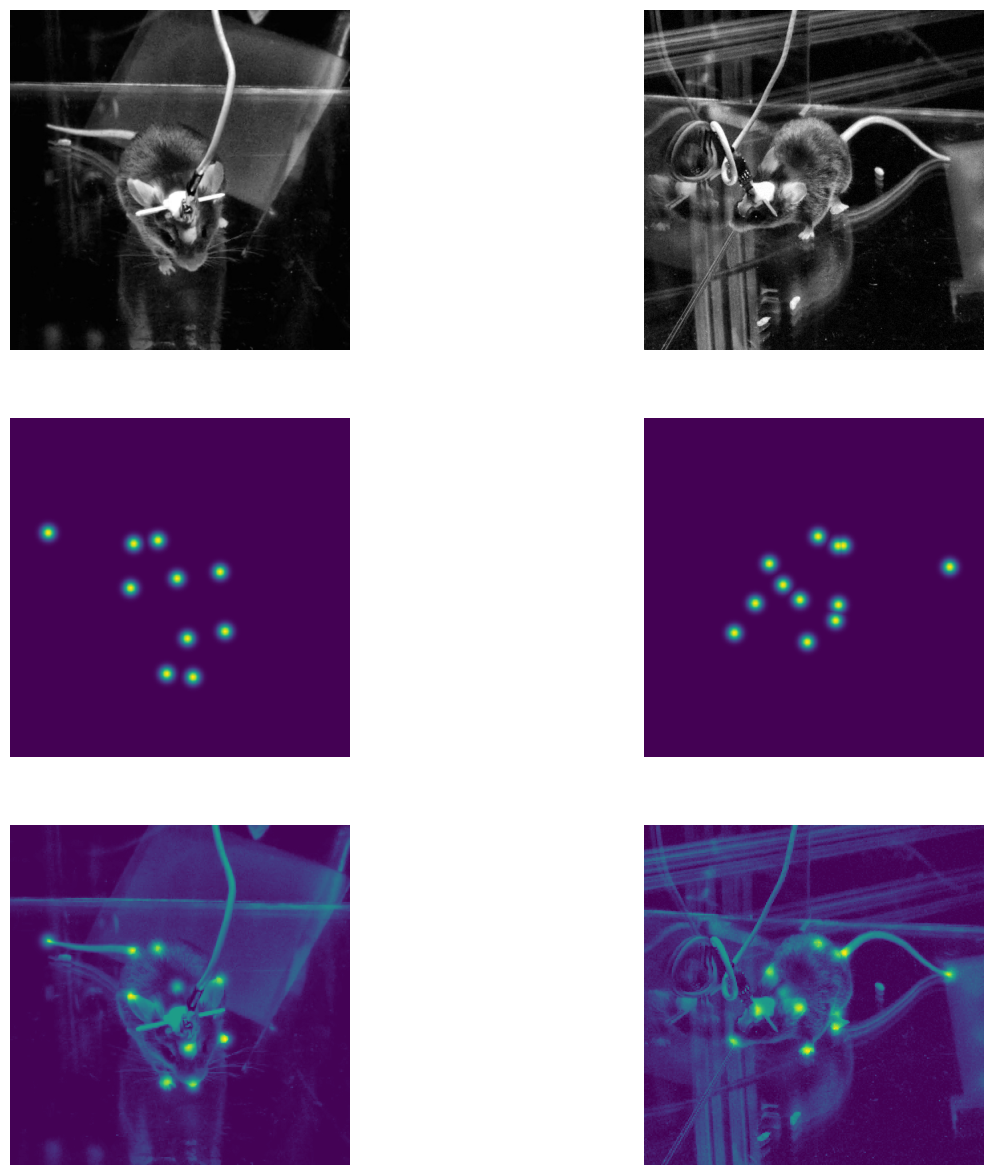

In [10]:
img,hm = next(iter(train_loader))
fig,axs = plt.subplots(3,2)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray)
    axs[1,i].imshow(hm[i].max(0)[0])
    axs[2,i].imshow(img[i][0][::2, ::2] + hm[i].max(0)[0].numpy())
for ax in axs.flat: 
    ax.axis('off')
fig.set_size_inches((15,15))


In [14]:
# bodyparts = [
#         "tail_tip",
#         "tail_base",
#         "spine_low",
#         "spine_mid",
#         "spine_high",
#         "left_ear",
#         "right_ear",
#         "forehead",
#         "nose_tip",
#         "left_hind_paw_front",
#         "left_hind_paw_back",
#         "right_hind_paw_front",
#         "right_hind_paw_back",
#         "left_fore_paw",
#         "right_fore_paw",
#     ]

## Prepare modeling

In [12]:
net_name = 'hrnet_side'
pretrain_dataset = 'imagenet_pretrained'
learning_rate = 1e-3
num_epochs = 250
mse = torch.nn.MSELoss()
model = HRNet(nof_joints=train_loader.dataset.num_keypoints)


In [12]:
checkpoint_dir = "./20240617_hrnet_from_scratch_side_checkpoints"

In [13]:
!ls 20240617_hrnet_from_scratch_side_checkpoints

hrnet_side_0.pth    hrnet_side_135.pth	hrnet_side_32.pth  hrnet_side_68.pth
hrnet_side_100.pth  hrnet_side_136.pth	hrnet_side_33.pth  hrnet_side_69.pth
hrnet_side_101.pth  hrnet_side_137.pth	hrnet_side_34.pth  hrnet_side_6.pth
hrnet_side_102.pth  hrnet_side_138.pth	hrnet_side_35.pth  hrnet_side_70.pth
hrnet_side_103.pth  hrnet_side_139.pth	hrnet_side_36.pth  hrnet_side_71.pth
hrnet_side_104.pth  hrnet_side_13.pth	hrnet_side_37.pth  hrnet_side_72.pth
hrnet_side_105.pth  hrnet_side_140.pth	hrnet_side_38.pth  hrnet_side_73.pth
hrnet_side_106.pth  hrnet_side_141.pth	hrnet_side_39.pth  hrnet_side_74.pth
hrnet_side_107.pth  hrnet_side_142.pth	hrnet_side_3.pth   hrnet_side_75.pth
hrnet_side_108.pth  hrnet_side_143.pth	hrnet_side_40.pth  hrnet_side_76.pth
hrnet_side_109.pth  hrnet_side_144.pth	hrnet_side_41.pth  hrnet_side_77.pth
hrnet_side_10.pth   hrnet_side_145.pth	hrnet_side_42.pth  hrnet_side_78.pth
hrnet_side_110.pth  hrnet_side_146.pth	hrnet_side_43.pth  hrnet_side_79.pth
hrnet_side_111

In [14]:
# training from scatch
# model = load_pretrained(model, pretrain_dataset)
# checkpoint_dir = './20240617_hrnet_from_scratch_side_checkpoints'
# current_epoch = 0
# model = model.to('cuda')
# if not os.path.exists(checkpoint_dir) or len(os.listdir(checkpoint_dir))==0:
#     os.makedirs(checkpoint_dir, exist_ok=True)

# training from checkpoint
checkpoint_dir = "./20240617_hrnet_from_scratch_side_checkpoints"
chkpt_epoch = 152
start_path = os.path.join(checkpoint_dir, f'{net_name}_{chkpt_epoch}.pth')
current_epoch = chkpt_epoch + 1
pretrained_weights = torch.load(start_path)
model.load_state_dict(pretrained_weights)
model = model.to('cuda')

# training from pretrained weights
# current_epoch = 0
# weights = torch.load('/n/groups/datta/6cam_keypoint_networks/caleb/24_01_29_jp_6cam_rig/weights/hrnet_bottom.pth')
# model.load_state_dict(weights)
# model = model.to('cuda')

## Do modeling

### Train stage

In [21]:
import time

In [ ]:
history = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(current_epoch, current_epoch + num_epochs):
    train_losses = []
    tic = time.time()
    for x, y in tqdm(train_loader):
        x = x.to('cuda')
        y = y.to('cuda')
        model = model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = mse(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        del x, y, y_pred

    # save at the end of each epoch
    save_path = os.path.join(checkpoint_dir, f'{net_name}_{epoch}.pth')
    torch.save(model.state_dict(), save_path)

    toc = time.time()
    print(f"Epoch {epoch}: elapsed time {np.round((toc - tic)/60)} minutes")
    
    test_losses = []
    for x, y in tqdm(test_loader):
        with torch.no_grad():
            x = x.to('cuda')
            y = y.to('cuda')
            model = model.eval()
            y_pred = model(x)
            test_losses.append(mse(y_pred, y).item())
            del x, y, y_pred
            
    print(epoch, np.mean(train_losses), np.mean(test_losses))
    history.append((epoch, np.mean(train_losses), np.mean(test_losses)))


  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 106: elapsed time 10.0 minutes


  0%|          | 0/43 [00:00<?, ?it/s]

106 5.426161408983113e-05 0.00024326370323759093


  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 107: elapsed time 9.0 minutes


  0%|          | 0/43 [00:00<?, ?it/s]

107 5.180178994682011e-05 0.00023663072673560574


  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
h = np.array(history)
plt.plot(h[:,0],h[:,1], label="Train")
plt.plot(h[:,0],h[:,2], label="Test")
plt.yscale("log")
plt.legend()

### Eval stage
* can be useful if you have a high variance of image statistics in your training data, and you need to train the net on the global img statistics, not just within batches. (or can also increase the batch size / play with augmentation to try to make each batch more accurately reflect the full global variance, instead of having each batch be its own little snowflake)

In [18]:
# training from checkpoint
chkpt_epoch = 5
start_path = os.path.join(checkpoint_dir, f'{net_name}_{chkpt_epoch}.pth')
current_epoch = chkpt_epoch + 1
pretrained_weights = torch.load(start_path)
model.load_state_dict(pretrained_weights)
model = model.to('cuda')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/4)
model = model.eval()
history_2 = []
num_epochs = 250
for epoch in range(current_epoch, current_epoch + num_epochs):
    print(epoch)
    
    train_losses = []
    for x, y in tqdm(train_loader):
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x)
        loss = mse(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        del x, y, y_pred

    # save at the end of each epoch
    save_path = os.path.join(checkpoint_dir, f'{net_name}_{epoch}.pth')
    torch.save(model.state_dict(), save_path)
    
    test_losses = []
    for x, y in tqdm(test_loader):
        with torch.no_grad():
            x = x.to('cuda')
            y = y.to('cuda')  
            y_pred = model(x)
            test_losses.append(mse(y_pred, y).item())
            del x, y, y_pred
            
    print(epoch, np.mean(train_losses), np.mean(test_losses))
    history_2.append((epoch, np.mean(train_losses), np.mean(test_losses)))


23


  0%|          | 0/123 [00:00<?, ?it/s]

/tmp/ipykernel_8194/2842724954.py:68: RuntimeWarning: invalid value encountered in divide
  crop_center = keypoints.sum(0)/(1-keypoints_mask).sum(0)
/tmp/ipykernel_8194/2842724954.py:69: RuntimeWarning: invalid value encountered in cast
  crop_center = (crop_center + np.random.normal(0,1,(2,))).astype(int)


  0%|          | 0/14 [00:00<?, ?it/s]

23 0.00022683572136499822 0.00021372933718209554
24


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

24 0.0002082905939607919 0.00020933778120836775
25


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

25 0.00020393764258720118 0.00020685463511784161
26


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

26 0.00020064986390165788 0.00020934923148680746
27


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

27 0.0001991075442060904 0.00020925838907714933
28


  0%|          | 0/123 [00:00<?, ?it/s]

## Assess results

In [81]:
# checkpoint_dir = "./hrnet_bottom_checkpoints"
# # checkpoint_dir = "./tmp_checkpoints"
# pretrained_weights = torch.load(os.path.join(checkpoint_dir, f'hrnet_bottom_5.pth'))
# model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [15]:
model = model.eval()

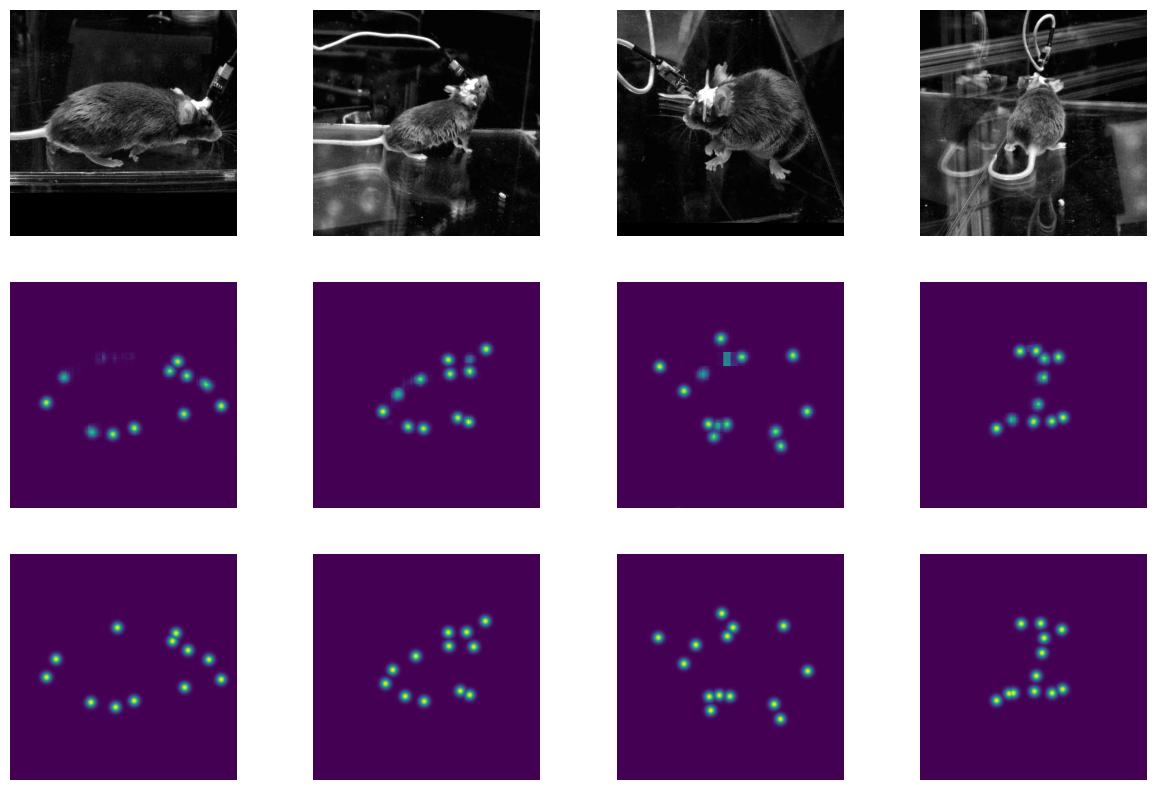

In [24]:
img,hm = next(iter(test_loader))
y = model(img.to('cuda')).detach().cpu().numpy()
img = img.numpy()
hm = hm.numpy()
fig,axs = plt.subplots(3,4)
for i in range(axs.shape[1]):
    axs[0,i].imshow(img[i][0], cmap=plt.cm.gray, vmin=0, vmax=1)
    axs[1,i].imshow(y[i][:].max(0), vmin=0, vmax=1)
    axs[2,i].imshow(hm[i][:].max(0), vmin=0, vmax=1)
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,10))

In [19]:
from skimage.transform import resize

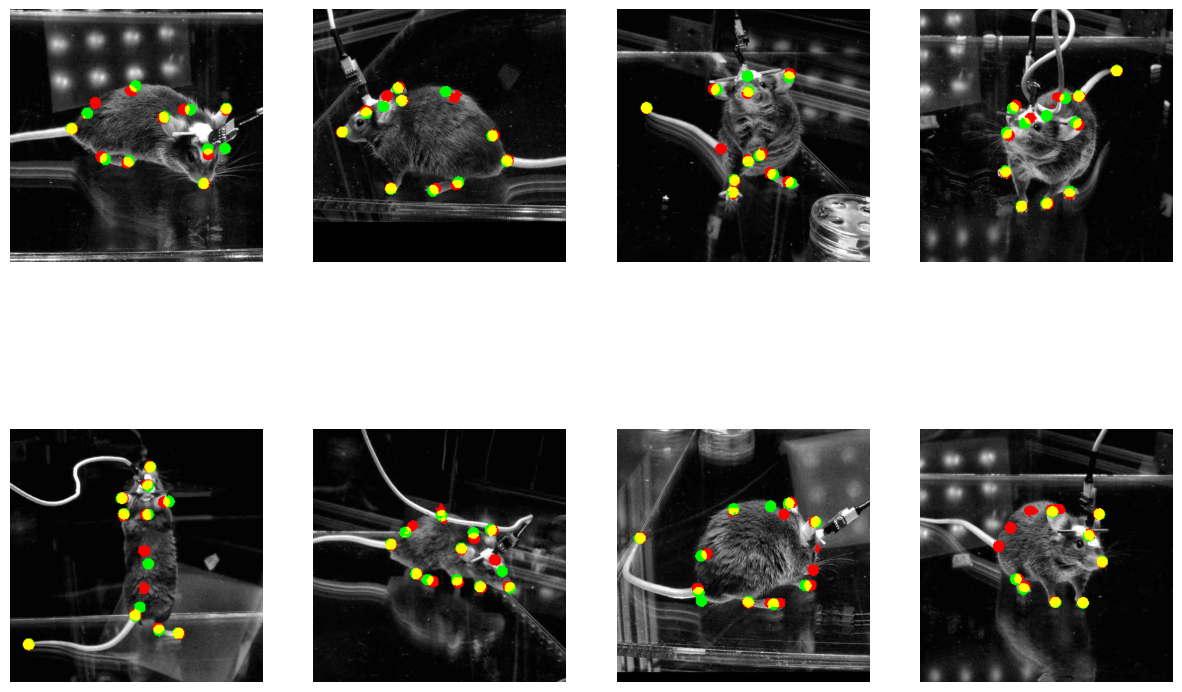

In [33]:
conf_thresh_to_show = 0.25

img,hm = next(iter(test_loader))
y = model(img.to('cuda')).detach().cpu().numpy()
img = img.numpy()
hm = hm.numpy()
fig,axs = plt.subplots(2,4)

for i in range(axs.size):
    _img = img[i][0]
    _hm = hm[i][0]
    
    # show model detections in red, ground truth in green, overlap in yellow
    y_marks = (y[i][:].max(0) > conf_thresh_to_show)
    y_marks = resize(y_marks, (512, 512))
    
    # ground truth labels
    hm_marks = (hm[i][:].max(0) > conf_thresh_to_show)
    hm_marks = resize(hm_marks, (512, 512))
    
    # Initialize the image
    y_im = np.stack([_img]*3, axis=-1)
    
    # Set model detections in red (only modify red channel)
    y_im[y_marks, 0] = 1  # Red
    y_im[y_marks, 1] = 0  # Green
    y_im[y_marks, 2] = 0  # Blue
    
    # Set ground truth in green (only modify green channel)
    y_im[hm_marks, 0] = 0  # Red
    y_im[hm_marks, 1] = 1  # Green
    y_im[hm_marks, 2] = 0  # Blue
    
    # Combine red and green where they overlap to make yellow
    overlap = y_marks & hm_marks
    y_im[overlap, 0] = 1  # Red
    y_im[overlap, 1] = 1  # Green
    y_im[overlap, 2] = 0  # Blue
    
    axs.flat[i].imshow(y_im)

for ax in axs.flat: 
    ax.axis('off')
fig.set_size_inches((15,10))

In [ ]:
checkpoints_to_test = np.arange(0, 200, 5)
# checkpoints_to_test = np.arange(20, 40, 1)
mean_losses = np.zeros(checkpoints_to_test.shape)
checkpoint_dir = "./20240617_hrnet_from_scratch_side_checkpoints"
net_name = 'hrnet_side'

for iCh, chkpt_epoch in enumerate(checkpoints_to_test):
    
    start_path = os.path.join(checkpoint_dir, f'{net_name}_{chkpt_epoch}.pth')
    if not os.path.exists(start_path):
        continue
    print(start_path)
    pretrained_weights = torch.load(start_path)
    model.load_state_dict(pretrained_weights)
    model = model.to('cuda')
    model = model.eval()

    test_losses = np.zeros((len(test_loader),1))
    for iTest, (x, y) in enumerate(test_loader):
        with torch.no_grad():
            x = x.to('cuda')
            y = y.to('cuda')
            y_pred = model(x)
            test_losses[iTest] = mse(y_pred, y).item()
    
    mean_losses[iCh] = np.mean(test_losses)
    print(mean_losses[iCh])
    
plt.plot(checkpoints_to_test, mean_losses)
plt.yscale("log")
plt.ylabel("Loss (log)")
plt.xlabel("Epoch")
plt.title("Side")
# 

./20240617_hrnet_from_scratch_side_checkpoints/hrnet_side_0.pth
0.00044652457663052996
./20240617_hrnet_from_scratch_side_checkpoints/hrnet_side_5.pth
0.0002493852621545409
./20240617_hrnet_from_scratch_side_checkpoints/hrnet_side_10.pth


In [27]:
checkpoints_to_test[np.argmin(mean_losses[:(30)])]

25